## NBA 승부예측

In [1]:
#!pip install category_encoders==2.*
#!pip install eli5
#!pip install pandas-profiling==2.*
#!pip install pdpbox
#!pip install --upgrade xgboost

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import math
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, classification_report, roc_curve, ConfusionMatrixDisplay, roc_auc_score, accuracy_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")
import eli5
from eli5.sklearn import PermutationImportance

# 전처리)


https://www.kaggle.com/datasets/nathanlauga/nba-games

캐글 nba data 2004~2022.3

https://www.nba.com/stats/help/glossary 

NBA 스탯정보

games = 게임날짜,게임ID,게임상황,홈팀 ID,어웨이팀 ID,시즌,홈팀 ID,홈팀 득점,홈팀 필드골 성공율,홈팀 자유투 성공율, 홈팀 3점 성공율,홈팀 어시스트,홈팀 리바운드,어웨이팀 ID,어웨이팀 득점,어웨이팀 필드골 성공율, 어웨이팀 자유투 성공율, 어웨이팀 3점 성공율,어웨이팀,어시스트,어웨이팀 리바운드,경기결과

games_details = 게임ID,팀 ID,팀 약어,팀 연고지,선수 ID,선수 이름,스타팅포지션,코멘트(출전하지 않는 이유,부상 등),출전시간,필드골 성공,필드골 시도,필드골 비율,3점 성공,3점 시도,3점 비율,자유투 성공,자유투 시도,자유투 비율,공격리바운드,수비리바운드,총 리바운드,어시스트,스틸,블락 샷,턴오버,개인파울,총 득점,득점마진

players = 선수이름,팀 ID,선수 ID,시즌

ranking = 팀 ID,리그 ID (Only NBA),시즌 ID,게임날짜,컨퍼런스 (서부,동부),팀 이름,이번 시즌 게임 수,이번 시즌 승리 수,이번 시즌 패배 수,승리 비율,홈 경기 누적 결과,어웨이 경기 누적 결과,재경기

teams = 리그 ID,팀 ID,최초 NBA 합류,최대 NBA 합류,약어,닉네임,창설연도,도시,경기장 이름,경기장 최대 수용인원,구단주,매니저,코치,리그제휴

In [60]:
# teams.csv 데이터에서 팀 ID 와 팀 약어 정보만 추출
df_team = pd.read_csv('teams.csv')

In [61]:
df_team.columns

Index(['LEAGUE_ID', 'TEAM_ID', 'MIN_YEAR', 'MAX_YEAR', 'ABBREVIATION',
       'NICKNAME', 'YEARFOUNDED', 'CITY', 'ARENA', 'ARENACAPACITY', 'OWNER',
       'GENERALMANAGER', 'HEADCOACH', 'DLEAGUEAFFILIATION'],
      dtype='object')

In [62]:
#팀 ID와 팀이름만 추출

df_team = df_team[['TEAM_ID', 'ABBREVIATION']]

In [63]:
# 이전 경기 스탯으로 다음 경기의 결과를 예측해야하므로
# 타겟값인 'HOME_TEAM_WINS'을 1행씩 내려서 시프트
df = pd.read_csv('games.csv')
df1 = df[df['HOME_TEAM_ID']==1610612758]
df1['GAME_DATE_EST'] =pd.to_datetime(df1.GAME_DATE_EST)
df1 = df1.sort_values(by='GAME_DATE_EST')
df1 = df1.reset_index()
del df1['index']
df1 = df1.dropna()
df1['PREDICT'] = df1.sort_values(by='GAME_DATE_EST', ascending=False).groupby('HOME_TEAM_ID')['HOME_TEAM_WINS'].shift(1)
result = df1.dropna()

In [64]:
# 팀별로 이전경기 스탯으로 게임 결과 예측
for i in (1610612737, 1610612738, 1610612740, 1610612741, 1610612742,
       1610612743, 1610612745, 1610612746, 1610612747, 1610612748,
       1610612749, 1610612750, 1610612751, 1610612752, 1610612753,
       1610612754, 1610612755, 1610612756, 1610612757,
       1610612759, 1610612760, 1610612761, 1610612762, 1610612763,
       1610612764, 1610612765, 1610612766, 1610612739, 1610612744):
    df = pd.read_csv('games.csv')
    df1 = df[df['HOME_TEAM_ID']== i ]
    df1['GAME_DATE_EST'] = pd.to_datetime(df1.GAME_DATE_EST) # 'GAME_DATE_EST' datetime 타입으로 변경 (시간 순 정렬을 위함)
    df1 = df1.sort_values(by='GAME_DATE_EST') # 정렬
    df1 = df1.reset_index() # 인덱스 초기화
    del df1['index'] # 인덱스 행 제거
    df1 = df1.dropna() # 결측치 제거
    df1['PREDICT'] = df1.sort_values(by='GAME_DATE_EST', ascending=False).groupby('HOME_TEAM_ID')['HOME_TEAM_WINS'].shift(1)
    df1 = df1.dropna()
    result = pd.concat([result,df1],ignore_index=True)

In [65]:
result = result.sort_values(by='GAME_DATE_EST')

In [66]:
result = result.reset_index()
del result['index']

In [67]:
result = result.astype({'PREDICT':'int'})

In [68]:
result.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,PREDICT
0,2003-10-05,10300001,Final,1610612762,1610612742,2003,1610612762,90.0,0.457,0.735,...,41.0,1610612742,85.0,0.447,0.500,0.250,20.0,38.0,1,1
1,2003-10-06,10300002,Final,1610612763,1610612749,2003,1610612763,105.0,0.494,0.618,...,48.0,1610612749,94.0,0.427,0.700,0.154,20.0,43.0,1,0
2,2003-10-07,10300009,Final,1610612758,1610612746,2003,1610612758,101.0,0.467,0.871,...,39.0,1610612746,82.0,0.368,0.609,0.364,13.0,50.0,1,1
3,2003-10-07,10300004,Final,1610612742,1610612753,2003,1610612742,99.0,0.488,0.667,...,52.0,1610612753,89.0,0.408,0.727,0.350,15.0,34.0,1,1
4,2003-10-07,10300007,Final,1610612748,1610612755,2003,1610612748,86.0,0.352,0.647,...,55.0,1610612755,79.0,0.329,0.897,0.143,7.0,44.0,1,0


In [69]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25667 entries, 0 to 25666
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   GAME_DATE_EST     25667 non-null  datetime64[ns]
 1   GAME_ID           25667 non-null  int64         
 2   GAME_STATUS_TEXT  25667 non-null  object        
 3   HOME_TEAM_ID      25667 non-null  int64         
 4   VISITOR_TEAM_ID   25667 non-null  int64         
 5   SEASON            25667 non-null  int64         
 6   TEAM_ID_home      25667 non-null  int64         
 7   PTS_home          25667 non-null  float64       
 8   FG_PCT_home       25667 non-null  float64       
 9   FT_PCT_home       25667 non-null  float64       
 10  FG3_PCT_home      25667 non-null  float64       
 11  AST_home          25667 non-null  float64       
 12  REB_home          25667 non-null  float64       
 13  TEAM_ID_away      25667 non-null  int64         
 14  PTS_away          2566

In [70]:
# 필요한 컬럼만 추출 타겟은 'HOME_TEAM_WINS'
result= result[['HOME_TEAM_ID','VISITOR_TEAM_ID', 'SEASON', 'PTS_home', 'FG_PCT_home',
       'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 'TEAM_ID_away',
       'PTS_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away',
       'REB_away','PREDICT']]

In [71]:
# TEAM ID 숫자를 약어로 변경
for i in range(0,30):
    result = result.replace(df_team['TEAM_ID'][i],df_team['ABBREVIATION'][i])

In [73]:
# train, val, test 를 6:2:2 나누어줌
# test와 val 값을 최근 값으로 나누어줌
test = result[-5000:]
val = result[-10000:-5000]
train = result[:-10000]

In [74]:
train

,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,PREDICT
0,UTA,DAL,2003,90.0,0.457,0.735,0.143,23.0,41.0,DAL,85.0,0.447,0.500,0.250,20.0,38.0,1
1,MEM,MIL,2003,105.0,0.494,0.618,0.267,25.0,48.0,MIL,94.0,0.427,0.700,0.154,20.0,43.0,0
2,SAC,LAC,2003,101.0,0.467,0.871,0.444,19.0,39.0,LAC,82.0,0.368,0.609,0.364,13.0,50.0,1
3,DAL,ORL,2003,99.0,0.488,0.667,0.167,20.0,52.0,ORL,89.0,0.408,0.727,0.350,15.0,34.0,1
4,MIA,PHI,2003,86.0,0.352,0.647,0.222,15.0,55.0,PHI,79.0,0.329,0.897,0.143,7.0,44.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15662,MIA,PHI,2014,87.0,0.413,0.722,0.308,13.0,39.0,PHI,91.0,0.429,0.741,0.263,11.0,42.0,1
15663,ORL,BOS,2014,100.0,0.470,0.652,0.389,23.0,45.0,BOS,95.0,0.388,0.759,0.304,22.0,45.0,0
15664,LAL,GSW,2014,115.0,0.517,0.647,0.462,28.0,42.0,GSW,105.0,0.464,0.882,0.462,20.0,39.0,0
15665,MIA,CLE,2014,101.0,0.476,0.824,0.333,27.0,43.0,CLE,91.0,0.444,0.636,0.231,16.0,37.0,0


In [75]:
target = 'PREDICT'

In [76]:
train[target].value_counts()

1    9406
0    6261
Name: PREDICT, dtype: int64

In [77]:
train.shape , val.shape , test.shape

((15667, 17), (5000, 17), (5000, 17))

#### 시계열 데이터('GAME_DATE_EST')이기 때문에 Hold out 으로 진행
#### 최근 데이터가 test,val데이터기 때문에 Hold out 으로 진행
#### Cross validation 방법은 시계열 데이터에 부적합

In [78]:
features = train.drop(columns=[target]).columns

In [79]:
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

##### 방법1) 결정트리
##### 방법2) 랜덤포레스트
##### 방법3) xgboost

##### 기준모델

In [80]:
# mode(): Return the highest frequency value in a Series.
major = y_train.mode()[0]

# 타겟 샘플 수 만큼 0이 담긴 리스트를 만듭니다. 기준모델로 예측
y_pred_nor = [major] * len(y_train)

In [81]:
print("training accuracy: ", accuracy_score(y_train, y_pred_nor))

training accuracy:  0.6003702048892576


### 1)결정트리

In [82]:
pipe_tree = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    DecisionTreeClassifier(random_state=2, criterion='entropy')
)

pipe_tree.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['HOME_TEAM_ID', 'VISITOR_TEAM_ID',
                                     'TEAM_ID_away'],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(criterion='entropy', random_state=2))])

In [83]:
print('훈련 정확도', pipe_tree.score(X_train, y_train))
print('검증 정확도', pipe_tree.score(X_val, y_val))

훈련 정확도 1.0
검증 정확도 0.5162


#### 과적합 문제

In [84]:
y_val.value_counts(normalize=True)

1    0.5866
0    0.4134
Name: PREDICT, dtype: float64

In [85]:
# min_samples_leaf 사용

pipe_tree_2 = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    DecisionTreeClassifier(min_samples_leaf=10, random_state=2)
)

pipe_tree_2.fit(X_train, y_train)
print('훈련 정확도', pipe_tree_2.score(X_train, y_train))
print('검증 정확도', pipe_tree_2.score(X_val, y_val))
print('테스트 정확도', pipe_tree_2.score(X_test, y_test))

훈련 정확도 0.7776855811578477
검증 정확도 0.5202
테스트 정확도 0.5238


In [86]:
# max_depth 사용

pipe_tree_3 = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    DecisionTreeClassifier(max_depth=6, random_state=2)
)

pipe_tree_3.fit(X_train, y_train)
print('훈련 정확도', pipe_tree_3.score(X_train, y_train))
print('검증 정확도', pipe_tree_3.score(X_val, y_val))
print('테스트 정확도', pipe_tree_3.score(X_test, y_test))

훈련 정확도 0.6105189251292525
검증 정확도 0.5822
테스트 정확도 0.561


### 2) 랜덤포레스트

In [87]:
pipe_random = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=5000,n_jobs=-1, random_state=10, oob_score=True)
)

pipe_random.fit(X_train, y_train)
print('훈련 정확도', pipe_random.score(X_train, y_train))
print('검증 정확도', pipe_random.score(X_val, y_val))
print('테스트 정확도', pipe_random.score(X_test, y_test))

훈련 정확도 1.0
검증 정확도 0.5684
테스트 정확도 0.5554


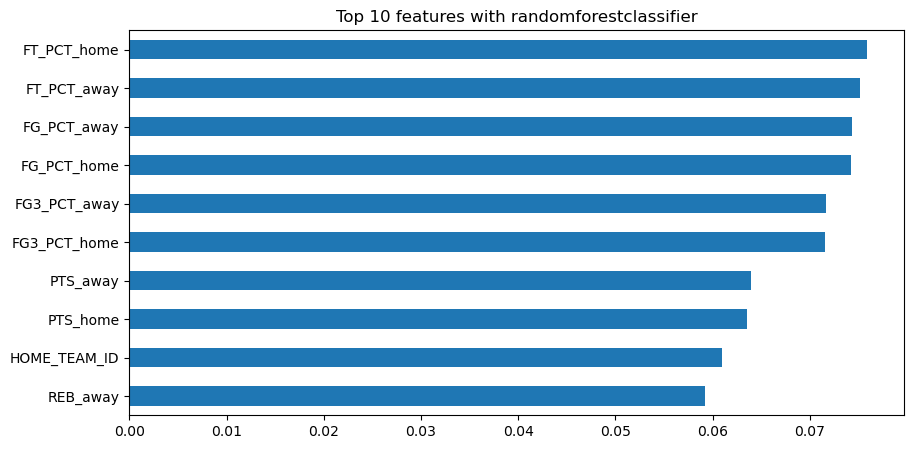

In [88]:
n = 10
rf_random = pipe_random.named_steps['randomforestclassifier']
importances_random = pd.Series(rf_random.feature_importances_, X_train.columns)
# %matplotlib inline
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features with randomforestclassifier')
importances_random.sort_values()[-n:].plot.barh();

In [89]:
pipe_rm = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
    ('rf', RandomForestClassifier(n_estimators=5000, random_state=2, n_jobs=-1)) 
])

In [90]:
pipe_rm.fit(X_train, y_train)
print('검증 정확도: ', pipe_rm.score(X_val, y_val))

검증 정확도:  0.5662


In [91]:
# permuter 정의
permuter = PermutationImportance(
    pipe_rm.named_steps['rf'], # model
    scoring='accuracy', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# permuter 계산은 preprocessing 된 X_val을 사용합니다.
X_val_transformed = pipe_rm.named_steps['preprocessing'].transform(X_val)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_val_transformed, y_val);

In [92]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

FG_PCT_away       -0.00916
FT_PCT_home       -0.00772
REB_home          -0.00628
AST_away          -0.00572
TEAM_ID_away      -0.00560
VISITOR_TEAM_ID   -0.00528
FT_PCT_away       -0.00504
REB_away          -0.00352
AST_home          -0.00316
FG_PCT_home       -0.00168
FG3_PCT_away      -0.00112
FG3_PCT_home      -0.00092
HOME_TEAM_ID      -0.00084
PTS_away          -0.00016
SEASON             0.00000
PTS_home           0.00200
dtype: float64

In [93]:
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.0020 ± 0.0076,PTS_home
0 ± 0.0000,SEASON
-0.0002 ± 0.0047,PTS_away
-0.0008 ± 0.0055,HOME_TEAM_ID
-0.0009 ± 0.0064,FG3_PCT_home
-0.0011 ± 0.0063,FG3_PCT_away
-0.0017 ± 0.0061,FG_PCT_home
-0.0032 ± 0.0016,AST_home
-0.0035 ± 0.0043,REB_away
-0.0050 ± 0.0034,FT_PCT_away


1. 홈팀의 전날 승리가 다음 경기에도 영향이 미치는가?
반반이며 영향이 미칠 수도 있고 아닐 수도 있다.
모델 또는 데이터 EDA가 쓰레기라는 의미라고 할 수 있습니다..

2. 전날 홈팀의 점수가 높다면 다음 경기에서도 홈팀이 이길확률이 높을까?
이거는 어느정도 Feature importance를 보면 홈팀의 점수가 관련성이 있다고 할 수 있다고 말할 수 있지만
관련 weight가 높지 않은 것으로 보아 많은 관련성이 있다고 보기는 힘들 것 같습니다..

일단은 계속 진행해보겠습니다..

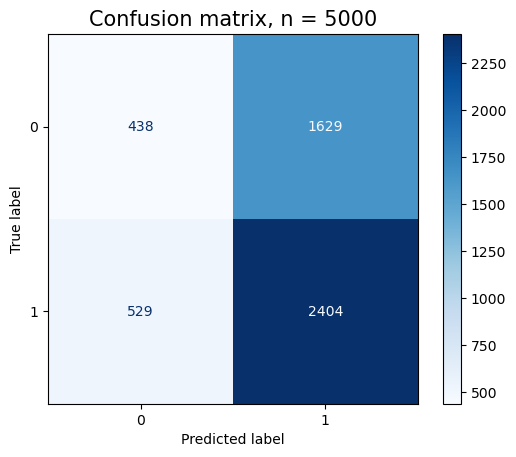

In [94]:
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe_random, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

In [95]:
y_pred = pipe_random.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred))

print(classification_report(y_val, y_pred))

검증 정확도:  0.5684
              precision    recall  f1-score   support

           0       0.45      0.21      0.29      2067
           1       0.60      0.82      0.69      2933

    accuracy                           0.57      5000
   macro avg       0.52      0.52      0.49      5000
weighted avg       0.54      0.57      0.52      5000



In [96]:
y_pred = pipe_random.predict(X_test)
print('테스트 정확도: ', accuracy_score(y_test, y_pred))

print(classification_report(y_pred, y_test))

테스트 정확도:  0.5554
              precision    recall  f1-score   support

           0       0.20      0.49      0.29       917
           1       0.83      0.57      0.68      4083

    accuracy                           0.56      5000
   macro avg       0.52      0.53      0.48      5000
weighted avg       0.72      0.56      0.61      5000



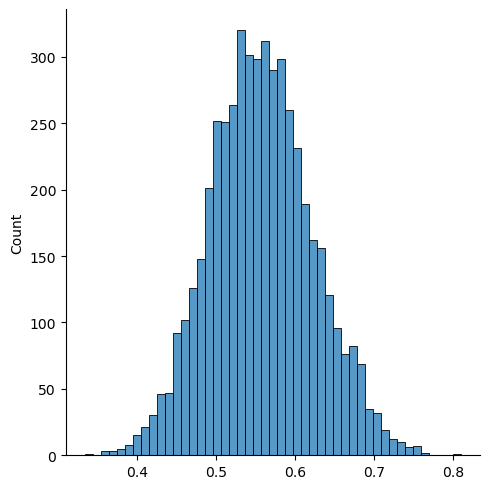

In [97]:
y_pred_proba = pipe_random.predict_proba(X_val)[:, 1]
sns.displot(y_pred_proba);

In [98]:
# roc_curve(타겟값, prob of 1)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})
roc

,FPR(Fall-out),TPRate(Recall),Threshold
0,0.000000,0.000000,1.8098
1,0.000000,0.000341,0.8098
2,0.000000,0.001023,0.7600
3,0.000000,0.001705,0.7552
4,0.000000,0.003409,0.7502
...,...,...,...
1207,0.998549,0.999318,0.3712
1208,0.998549,0.999659,0.3686
1209,0.999032,0.999659,0.3612
1210,0.999032,1.000000,0.3558


In [99]:
# threshold 최대값의 인덱스, np.argmax()
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print('idx:', optimal_idx, ', threshold:', optimal_threshold)


idx: 505 , threshold: 0.5806


In [100]:
y_pred_optimal = y_pred_proba >= optimal_threshold
print(classification_report(y_val, y_pred_optimal))

              precision    recall  f1-score   support

           0       0.45      0.70      0.54      2067
           1       0.65      0.39      0.48      2933

    accuracy                           0.52      5000
   macro avg       0.55      0.54      0.51      5000
weighted avg       0.56      0.52      0.51      5000



In [101]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_val, y_pred_proba)
auc_score

0.5498281157757899

### 3) xgboost

In [102]:
pipe_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    XGBClassifier(n_estimators=5000
                  , random_state=2
                  , n_jobs=-1
                  , max_depth=6
                  , learning_rate=0.2
                 )
)

pipe_xgb.fit(X_train, y_train);

In [103]:
y_pred = pipe_xgb.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred))

print(classification_report(y_pred, y_val))

검증 정확도:  0.525
              precision    recall  f1-score   support

           0       0.45      0.43      0.44      2150
           1       0.58      0.60      0.59      2850

    accuracy                           0.53      5000
   macro avg       0.51      0.51      0.51      5000
weighted avg       0.52      0.53      0.52      5000



In [104]:
y_pred = pipe_xgb.predict(X_test)
print('테스트 정확도: ', accuracy_score(y_test, y_pred))

print(classification_report(y_pred, y_test))

테스트 정확도:  0.5038
              precision    recall  f1-score   support

           0       0.42      0.44      0.43      2143
           1       0.57      0.56      0.56      2857

    accuracy                           0.50      5000
   macro avg       0.50      0.50      0.50      5000
weighted avg       0.51      0.50      0.50      5000



전체적으로 생각한 결과 이전 경기의 스탯이라는 타겟 자체의 목적성이 불확실했으며 선수의 뎁스가 변경되거나 부상의 여지 등 여러가지 변경되는 점이 많아서 정확하지 않았다. 

처음 농구 사이트의 데이터를 통해서 선수들의 데이터를 가지고와서 그 선수가 출전하냐 안하냐의 결과와 스탯도 컬럼으로 넣어서 kaggle의 데이터와 같이 EDA를 진행을 한다면 더 관련성 있는 컬럼들을 가지고 정확도를 높일 수 있을 것 같다. 

https://www.basketball-reference.com/
